## Marcel Pinheiro
## marcelpinheiro@gmail.com


## Instructions

In [1]:
!pip install pyspark
!pip install docker

You should consider upgrading via the 'C:\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import docker

In [3]:
sc = SparkSession.builder.appName('strider').getOrCreate()

### External data provided by vendor

#### Authors

In [4]:
authors = sc.read.json("data-dump\\authors.json")
authors.show(5)


+--------------------+--------------------+--------------+-----------------+
|          birth_date|             died_at|          name|      nationality|
+--------------------+--------------------+--------------+-----------------+
|1956-05-07T00:00:...|                null| Josh Johnston|Guianese (French)|
|2000-06-30T00:00:...|2042-08-07T00:00:...|     Al Hamill|        Armenians|
|1975-12-07T00:00:...|2049-02-24T00:00:...|Wilmer Reichel|        Andorrans|
|1930-07-14T00:00:...|1982-04-14T00:00:...| Garland Lynch|     Singaporeans|
|1967-02-25T00:00:...|1994-01-01T00:00:...|Napoleon Terry|          Kenyans|
+--------------------+--------------------+--------------+-----------------+
only showing top 5 rows



#### Books

In [5]:
books = sc.read.json("data-dump\\books.json")
books.show(5)

+--------------------+--------------------+-----+-------------------+
|              author|                name|pages|          publisher|
+--------------------+--------------------+-----+-------------------+
|    Ms. Dorsey Grant|    An Evil Cradling| 6302|Harcourt Assessment|
|     Alexa Dickinson|      As I Lay Dying| 8934|     Pavilion Books|
|  Eneida Considine V|    Recalled to Life| 8195| Sidgwick & Jackson|
|       Darcie Abbott|      The Waste Land| 8608|     Left Book Club|
|Salvatore Herman PhD|Bury My Heart at ...| 6376|        Cisco Press|
+--------------------+--------------------+-----+-------------------+
only showing top 5 rows



#### Reviews

In [6]:
reviews = sc.read.json("data-dump\\reviews.json")
reviews.show(5)

+------------------+--------------------+----+--------------------+
|              book|               movie|rate|              resume|
+------------------+--------------------+----+--------------------+
|A Passage to India|Beauty and the Beast|   1|Solitudo magnam v...|
|    The Man Within|Star Wars: Episod...|   5|Adhuc ad velum. C...|
|       Vanity Fair|    The Big Lebowski|   1|Tersus velit asse...|
|The Moving Toyshop|        Mary and Max|   5|Pecco quis magni....|
|     Endless Night|   L.A. Confidential|   3|Tyrannus audio au...|
+------------------+--------------------+----+--------------------+
only showing top 5 rows



### Internal data

#### Users

In [7]:
users = sc.read.csv("data-dump\\users.csv",header=True)
users.show(5)


+----------+---------+--------------------+
|first_name|last_name|               email|
+----------+---------+--------------------+
|      Eddy|   Kirlin|karine@bode-rogah...|
|     Elvia|     Conn|janet_haag@crist.biz|
|   Ezekiel|    Block|    landon@bauch.org|
|      Hugh| Nikolaus|grover_terry@metz...|
|      Iona|    Huels|  clelia@wuckert.com|
+----------+---------+--------------------+
only showing top 5 rows



#### Movies

In [8]:
movies = sc.read.csv("data-dump\\movies.csv",header=True)
movies.show(5)


+----------------+-------------+-----------------+-------+
|           title|duration_mins|original_language|size_mb|
+----------------+-------------+-----------------+-------+
|The Great Escape|          113|           Korean|    876|
|   The Third Man|          129|           French|   1857|
| Cinema Paradiso|          102|          Russian|    676|
|        Scarface|          112|         Japanese|   1236|
|         Vertigo|          146|          Italian|    649|
+----------------+-------------+-----------------+-------+
only showing top 5 rows



#### Streams

In [9]:
streams = sc.read.csv("data-dump\\streams.csv",header=True)
streams.show(5,False)

+------------------------------------------+----------------------------------+------------------+----------------------------+----------------------------+
|movie_title                               |user_email                        |size_mb           |start_at                    |end_at                      |
+------------------------------------------+----------------------------------+------------------+----------------------------+----------------------------+
|Full Metal Jacket                         |rodrick_bergnaum@murray.co        |613.4245936603365 |2021-12-06T19:30:19.099+0100|2021-12-07T15:44:38.177+0100|
|Rush                                      |nolan.wintheiser@nienow-mante.name|330.524118447188  |2021-12-15T04:36:50.500+0100|2021-12-15T05:57:52.266+0100|
|Star Wars: Episode VII - The Force Awakens|willie.baumbach@dietrich.io       |2101.559005489579 |2021-12-12T22:32:02.628+0100|2021-12-13T20:37:34.407+0100|
|The Bridge on the River Kwai              |catalina_rath@

### **Phase 1** 
Build an Extract, Transform, Load (ETL) pipeline that will take this data and move it into a production-ready database that can be easily queried to answer questions for the business.


**Solution**: I will create spark temporary views to query the data. Using this resource I don't need to storage anything in some database to be able to query the data

In [10]:
authors.createOrReplaceTempView('authors')
books.createOrReplaceTempView('books')
reviews.createOrReplaceTempView('reviews')

users.createOrReplaceTempView('users')
movies.createOrReplaceTempView('movies')
streams.createOrReplaceTempView('streams')

### Phase 2

#### What percentage of the streamed movies are based on books?

In [11]:
sc.sql('''
        Select round(count(distinct r.movie) * 100 / count(distinct s.movie_title),2) as PercentageOfStreamedMoviesBasedOnBooks
        from streams s 
        left join reviews r on s.movie_title = r.movie ''').show()

+--------------------------------------+
|PercentageOfStreamedMoviesBasedOnBooks|
+--------------------------------------+
|                                 93.41|
+--------------------------------------+



#### How many users were watching "Unforgiven" on Christmas morning (between 7 am and 12 noon on December 25)?

In [16]:
sc.sql('''
        Select 
            count(distinct user_email) NumberOfUsersWatchingUnforgiven
            from streams s
            where movie_title = 'Unforgiven'
            and to_timestamp(start_at) between '2021-12-25 07:00:00.000' and '2021-12-25 12:00:00.000'                                    
            ''').show(1000,False)

# Where I live we use GMT-4

+-------------------------------+
|NumberOfUsersWatchingUnforgiven|
+-------------------------------+
|1                              |
+-------------------------------+



#### How many movies based on books written by Singaporeans authors were streamed that month?

In [13]:
sc.sql('''
        Select            
            count(distinct s.movie_title)
            from streams s
            inner join reviews r on r.movie = s.movie_title
            inner join books b on b.name = r.book
            inner join authors a on a.name = b.author
            where a.nationality = 'Singaporeans'
            and to_date(start_at) between '2021-12-01' and '2021-12-31'
            
            ''').show(100,False)



+---------------------------+
|count(DISTINCT movie_title)|
+---------------------------+
|3                          |
+---------------------------+



#### What's the average streaming duration?

In [14]:
sc.sql('''
        Select            
            
            Round(
            AVG(
                (unix_timestamp(to_timestamp(end_at)) - unix_timestamp(to_timestamp(start_at))) /3600
                )
                )AvgStreamingDurationInHours
            from streams
            
            ''').show(100,False)



+---------------------------+
|AvgStreamingDurationInHours|
+---------------------------+
|12.0                       |
+---------------------------+



#### What's the median streaming size in gigabytes?

In [17]:
sc.sql('''
        Select            
            percentile_approx((size_mb/1024),0.5) as median
            

            
            from streams
            
            ''').show()



+------------------+
|            median|
+------------------+
|0.9135149380011914|
+------------------+



#### How many users watched at least 50% of any movie in the last week of the month (7 days)?

In [114]:
sc.sql('''
        Select
            count(distinct user_email)
            

            from streams s            
            left join movies m on m.title = s.movie_title
            WHERE
            
            (((bigint(to_timestamp(end_at)))-(bigint(to_timestamp(start_at))))/(60)) * 100 / m.duration_mins >= 50
            and to_date(start_at) >= to_date('2021-12-31') - Interval 1 week
            ''').show(20,False)            

sc.sql('''
        Select
            user_email,
            movie_title,
            start_at,
            end_at,
            m.duration_mins,
            round((((bigint(to_timestamp(end_at)))-(bigint(to_timestamp(start_at))))/(60)),2) as diff,
            round(((((bigint(to_timestamp(end_at)))-(bigint(to_timestamp(start_at))))/(60)) * 100 / m.duration_mins),2) perc
            
            

            from streams s            
            left join movies m on m.title = s.movie_title
            WHERE
            
            (((bigint(to_timestamp(end_at)))-(bigint(to_timestamp(start_at))))/(60)) * 100 / m.duration_mins >= 50
            and to_date(start_at) >= to_date('2021-12-31') - Interval 1 week
                      
            order by movie_title
            
            
            ''').show(20,False)


#It seems sometimes the user take a lot of time to watch a movie. Example:     
#leif_ryan@friesen.info watched Angry Men starting at 2021-12-28 05:55:55 
# and finishing at 2021-12-28 09:28:48 So it tooks 212.88 minutes to watch a 50 minutes movie. 
# If the user pauses and wacth later it will count all the period?
            
            
            


+--------------------------+
|count(DISTINCT user_email)|
+--------------------------+
|739                       |
+--------------------------+

+----------------------------------------+----------------+----------------------------+----------------------------+-------------+-------+-------+
|user_email                              |movie_title     |start_at                    |end_at                      |duration_mins|diff   |perc   |
+----------------------------------------+----------------+----------------------------+----------------------------+-------------+-------+-------+
|leif_ryan@friesen.info                  |12 Angry Men    |2021-12-28T05:55:55.136+0100|2021-12-28T09:28:48.186+0100|50           |212.88 |425.77 |
|rolf_west@robel.biz                     |12 Angry Men    |2021-12-27T02:41:42.737+0100|2021-12-27T15:09:17.934+0100|50           |747.58 |1495.17|
|emilie@zboncak.name                     |12 Angry Men    |2021-12-29T05:31:54.890+0100|2021-12-29T09:31:34.451+01

### Phase 3

#### In **as much detail as time provides**, describe how you would build this pipeline if you had more time for the test and planned to ship it in a production environment.

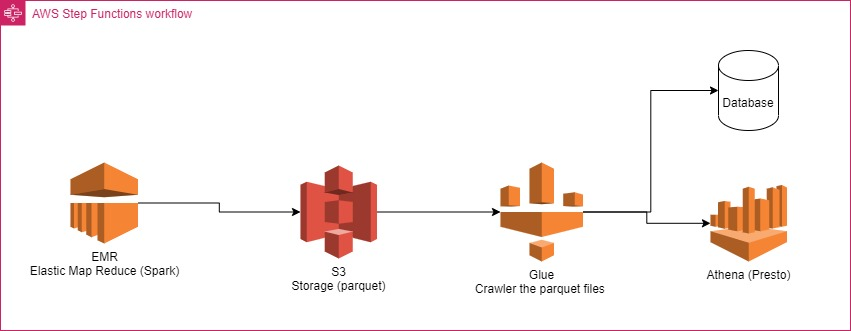

Using AWS:

- I would create a Lambda script that starts an EMR transient cluster and runs a python scripts that connect into the ftp server, download the files, and work an ETL solution.
- I chose Python because is easier to work. If I have to work with huge amount of data, i would use scala instead
- After ETL, it would be save the data in parquet files inside the S3 (data lake)
- When the EMR cluster finishes their job, it terminates (shutdown) automatically. I don't need a cluster running 24/7, only when the data arrives, saving costs.
- With Glue, I can or run the Crawler to create the tables based on the parquet files and query the data using Athena, or I can create a Glue Job (that runs spark under the hood) to send the data into the database.
- Since the data comes every day, 2am, I would choose Step Functions to orchestrate my pipeline, running in that time. It's serverless and cheap.
- Every day the whole dataset will be downloaded, so, in step functions I would add a step to delete all the data before to load the new data the arrives from the ftp server OR i would activate the Job bookmark from Glue to loaded only the new data that arrives
- It's common errors during the data pipeline run, like for example the ftp server down. So inside step functions, i would set catchers and retries to try to run again.

    